# 0. Imports & inputs & introductions

This files is written to compare the data sent from James Sturch to compare the mismatch results using Solar Edge system. The email was sent by Jame Sturch and the date was 20/11/2024.

In [1]:
# imports
import os
import sys
import time
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
import imageio
import datetime
from datetime import timedelta
import scipy.constants as const
import matplotlib.dates as mdates


# data folder direcotry
data_dir = r"C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Data"
# direrctory for saving results
base_dir = r"C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results"

In [2]:
# define the function to calculate the I0 at MPPT
def I0(I, V, Rs, Rsh, n, N, vth):
    # calculate the exponential term
    exp_term = np.exp(-(V + I * Rs) / (n * N * vth))
    # calculate the fraction term
    frac_term = n * N * vth / V
    # calculate hte numerator
    numerator = I*(1 + Rs/Rsh) - V/Rsh
    # calculate the denominator
    denominator = 1 - I * Rs / V
    # put them together
    I0 = numerator / denominator * frac_term * exp_term
    return I0

# define the function to calculate IL at MPPT
def IL(I, V, Rs, Rsh, n, N, vth, I0):
    # calculate the first term
    first_term = I * (1 + Rs/Rsh)
    # calculate the second term
    second_term = V / Rsh
    # calculate the third term
    third_term = I0*(np.exp((V + I * Rs) / (n * N * vth)) - 1)
    # put them together
    IL = first_term + second_term + third_term
    return IL


# 1. Read & visualise

## 1.1. Find the site

In [3]:
# Define the site to read
site_id = '1398284'  # Site identifier
# site_id = '347166'

# define the season
season = 'summer'
# season = 'winter'

# Find the directory containing the site_id
site_dir = [d for d in os.listdir(data_dir) if site_id in d][0]

# Full path to the site directory
site_dir = os.path.join(data_dir, site_dir)


## 1.2. Season data extraction

### 1.2.1. Data extraction

In [4]:
# Find the folder that contains the word "summer"
summer_dir = [d for d in os.listdir(site_dir) if season in d][0]

# Full path to the summer directory
summer_dir = os.path.join(site_dir, summer_dir)

# Initialize an empty list to store the DataFrames
dataframes = []
reporter_ids = []

# Define a list of potential timestamp formats
timestamp_formats = [
    "%Y-%m-%d %H:%M:%S",
    "%d/%m/%Y %H:%M",
    "%m/%d/%Y %H:%M",
    "%Y-%d-%m %H:%M:%S",
    None  # Let pandas infer formats
]

# Loop through the files in the summer directory
for file in os.listdir(summer_dir):
    if 'optimizer_data' in file and file.endswith('.csv'):
        # Read the CSV file
        optimizer_data = pd.read_csv(os.path.join(summer_dir, file))

        # Extract the reporter_id from the file name
        reporter_id = file.split('_')[-1].split('.')[0]
        reporter_ids.append(reporter_id)

        # Rename the columns, including "power"
        optimizer_data.rename(columns={
            'panel_current': f'panel_current_{reporter_id}',
            'panel_voltage': f'panel_voltage_{reporter_id}',
            'temperature': f'temperature_{reporter_id}',
            'panel_temperature': f'panel_temperature_{reporter_id}',
            'power': f'power_{reporter_id}'
        }, inplace=True)

        # Rename the first column to "Timestamp"
        optimizer_data.rename(columns={optimizer_data.columns[0]: 'Timestamp'}, inplace=True)


        # Convert the "Timestamp" column to a datetime
        for fmt in timestamp_formats:
            try:
                optimizer_data['Timestamp'] = pd.to_datetime(optimizer_data['Timestamp'], format=fmt)
                break
            except (ValueError, TypeError):
                pass

        # set hte index to the timestamp
        optimizer_data.set_index('Timestamp', inplace=True)

        # Drop any other columns except the renamed ones
        optimizer_data = optimizer_data[[f'panel_current_{reporter_id}',
                                         f'panel_voltage_{reporter_id}',
                                         f'temperature_{reporter_id}',
                                         f'panel_temperature_{reporter_id}',
                                         f'power_{reporter_id}']]

        # Append the DataFrame to the list
        dataframes.append(optimizer_data)


# make sure all files have the same Timestamps
# find hte earliest and latest timestamps
earliest_timestamp = max([df.index[0] for df in dataframes])
latest_timestamp = min([df.index[-1] for df in dataframes])
# create a list of dataframe start with the earliest timestamp and end with the latest timestamp with step of 5 min
new_index = pd.date_range(start=earliest_timestamp, end=latest_timestamp, freq='5T')
# reindex the dataframes
for i in range(len(dataframes)):
    # loop through the new index
    for index in new_index:
        # check if the index is in the dataframe
        if index not in dataframes[i].index:
            # create a new row with all values as interpolated vlaues before and after
            dataframes[i].loc[index] = np.nan
    

# Merge all dataframes on the "Timestamp" index
if dataframes:
    merged_data = pd.concat(dataframes, axis=1)

# Reset the index for a clean dataframe
merged_data.reset_index(inplace=True)

print(merged_data)

               Timestamp  panel_current_99669233  panel_voltage_99669233  \
0    2024-01-10 06:40:00                0.129139               29.789735   
1    2024-01-10 06:45:00                0.155696               31.098101   
2    2024-01-10 06:50:00                0.187500               30.301064   
3    2024-01-10 06:55:00                0.195477               30.864309   
4    2024-01-10 07:00:00                0.225759               30.313084   
...                  ...                     ...                     ...   
2753 2024-01-19 20:05:00                0.769808               33.947661   
2754 2024-01-19 20:10:00                0.402325               34.365256   
2755 2024-01-19 20:15:00                0.248558               28.182692   
2756 2024-01-19 20:20:00                0.181250               26.500000   
2757 2024-01-19 20:25:00                     NaN                     NaN   

      temperature_99669233  panel_temperature_99669233  power_99669233  \
0            

### 1.2.2. Visualisation

               Timestamp  panel_current_99669233  panel_voltage_99669233  \
0    2024-01-10 06:40:00                0.129139               29.789735   
1    2024-01-10 06:45:00                0.155696               31.098101   
2    2024-01-10 06:50:00                0.187500               30.301064   
3    2024-01-10 06:55:00                0.195477               30.864309   
4    2024-01-10 07:00:00                0.225759               30.313084   
...                  ...                     ...                     ...   
2753 2024-01-19 20:05:00                0.769808               33.947661   
2754 2024-01-19 20:10:00                0.402325               34.365256   
2755 2024-01-19 20:15:00                0.248558               28.182692   
2756 2024-01-19 20:20:00                0.181250               26.500000   
2757 2024-01-19 20:25:00                     NaN                     NaN   

      temperature_99669233  panel_temperature_99669233  power_99669233  \
0            

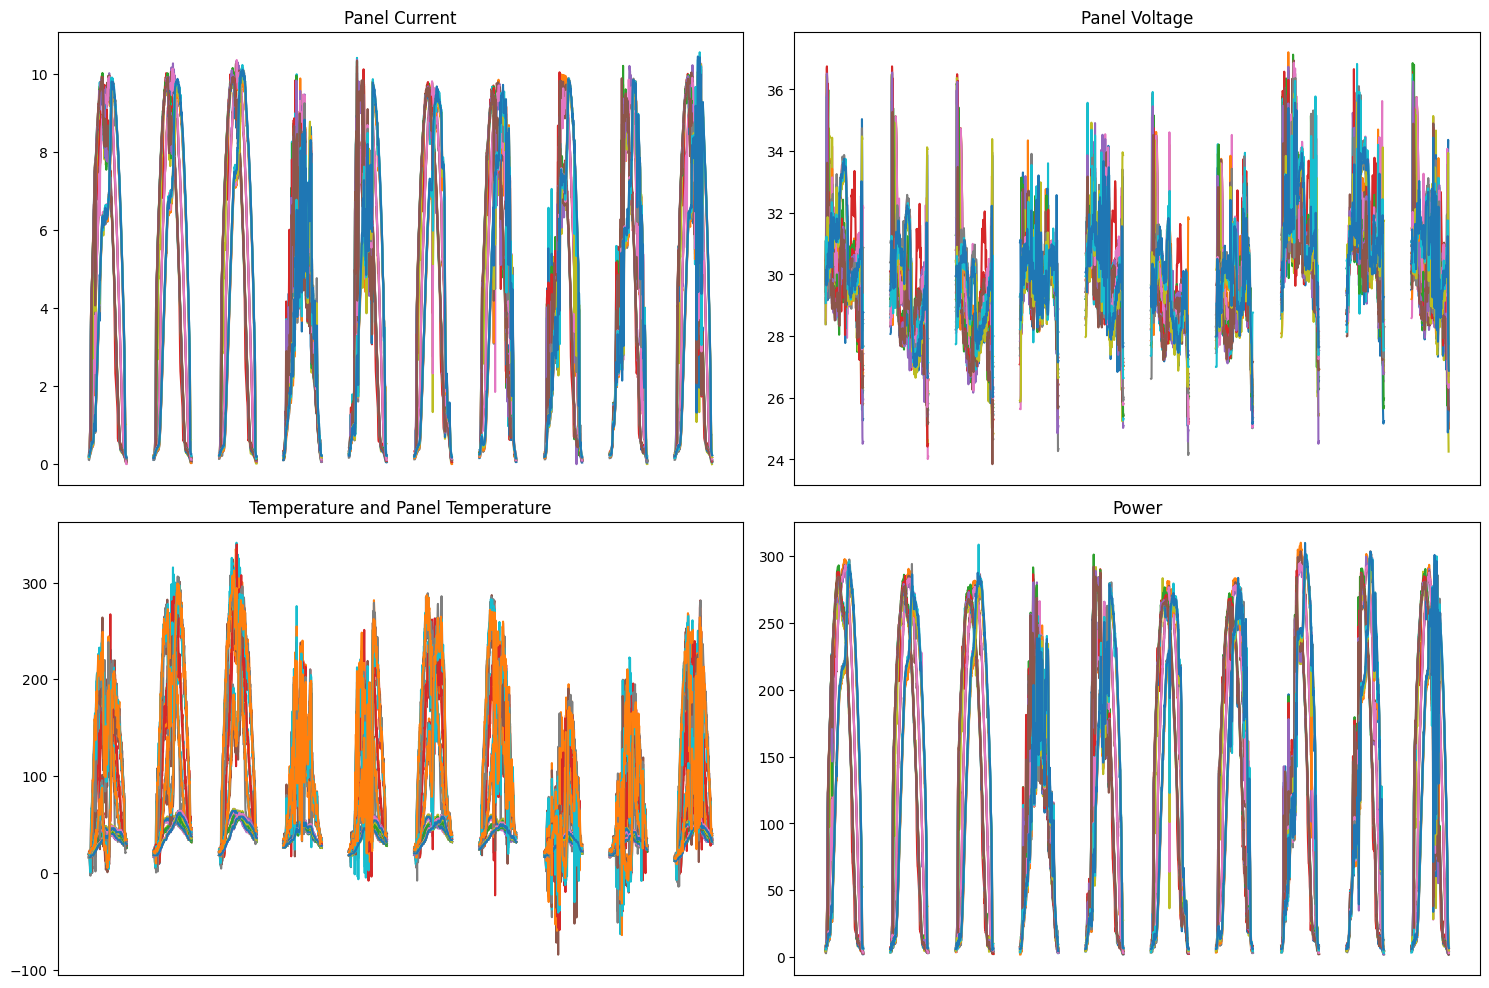

In [5]:
# Specify the number of days to plot
num_days_to_plot = 10

# Filter the data for the specified number of days
start_date = pd.to_datetime(merged_data['Timestamp'].iloc[0])
end_date = start_date + timedelta(days=num_days_to_plot)
filtered_data = merged_data[(pd.to_datetime(merged_data['Timestamp']) >= start_date) & 
                            (pd.to_datetime(merged_data['Timestamp']) < end_date)]

print(filtered_data)

# Create a 2x2 subplot for the data
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot all panel currents
for reporter_id in reporter_ids:
    axs[0, 0].plot(filtered_data['Timestamp'], filtered_data[f'panel_current_{reporter_id}'])
axs[0, 0].set_title('Panel Current')
axs[0, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all panel voltages
for reporter_id in reporter_ids:
    axs[0, 1].plot(filtered_data['Timestamp'], filtered_data[f'panel_voltage_{reporter_id}'])
axs[0, 1].set_title('Panel Voltage')
axs[0, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all temperatures and panel temperatures together
for reporter_id in reporter_ids:
    axs[1, 0].plot(filtered_data['Timestamp'], filtered_data[f'temperature_{reporter_id}'])
    axs[1, 0].plot(filtered_data['Timestamp'], filtered_data[f'panel_temperature_{reporter_id}'])
axs[1, 0].set_title('Temperature and Panel Temperature')
axs[1, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all powers
for reporter_id in reporter_ids:
    axs[1, 1].plot(filtered_data['Timestamp'], filtered_data[f'power_{reporter_id}'])
axs[1, 1].set_title('Power')
axs[1, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# 2. IV curve calculation

## 2.1. One diode model data extraction

The data of module they get it from PVsyst database, which is CS6K - 315MS from CSI Solar. Therefore I go to PVsyst, find the module and extract n, Ncell, Rs, Rsh, then put it below.

In [6]:
# Parameters for the one-diode model
if site_id == '347166':
    ideality_factor = 1.0081
    num_cells_series = 60
    thermal_voltage_25C = 0.0258
    series_resistance = 0.302
    shunt_resistance = 400
elif site_id == '1398284':
    ideality_factor = 0.954526056
    num_cells_series = 120
    thermal_voltage_25C = 0.0258
    series_resistance = 0.229
    shunt_resistance = 300

# Option to dynamically calculate vth based on panel temperature
use_dynamic_vth = True  # Set to True to enable dynamic calculation, False to use thermal_voltage_25C

# # Constants for vth calculation
boltzmann_constant = const.Boltzmann  # Boltzmann constant in J/K
electron_charge = const.e  # Elementary charge in C

## 2.2. Calculate IV curves from MPPT

In [11]:
# Get the current timestamp for directory naming
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# Create output directory
output_dir = os.path.join(base_dir, f'i_from_v/iv_curve_plots_{timestamp}_{season}_{site_id}')
os.makedirs(output_dir, exist_ok=True)

# Initialize data structures
image_files = []  # For GIF creation
iv_sum_data = pd.DataFrame(columns=['Timestamp', 'Sum of I*V (W)'])  # For IV curve data
isc_columns = ['Timestamp'] + [f"optimiser_{optimiser}" for optimiser in reporter_ids]
isc_data = pd.DataFrame(columns=isc_columns)  # For Isc values

# Determine fixed x and y axis limits for IV plotting
y_limit = (0, 13)
x_limit = (0, 50)

# Generate a range of currents and voltages for IV calculations
currents = np.linspace(0, y_limit[1], 100)
voltages = np.linspace(0, x_limit[1], 100)

# Loop through each time step in the data
for idx in range(len(merged_data)):
    # Initialize Isc row for this timestamp
    isc_row = {'Timestamp': pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')}

    # Skip this time step if all optimizers have NaN or zero values
    all_nan_or_zero = all(
        merged_data[f'panel_voltage_{optimiser}'].iloc[idx] == 0 or
        merged_data[f'panel_current_{optimiser}'].iloc[idx] == 0 or
        np.isnan(merged_data[f'panel_voltage_{optimiser}'].iloc[idx]) or
        np.isnan(merged_data[f'panel_current_{optimiser}'].iloc[idx])
        for optimiser in reporter_ids
    )
    if all_nan_or_zero:
        print(f"Time step {idx} has NaN or zero values for all optimizers.")
        continue

    # Create a new figure for IV plotting
    plt.figure(figsize=(10, 6))
    sum_iv = 0  # Initialize sum of I*V for this timestamp
    iv_curve_count = 0  # Counter for IV curves

    # Process each optimizer
    for optimiser in reporter_ids:
        optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
        optimiser_current = merged_data[f'panel_current_{optimiser}']
        panel_temperature = merged_data[f'panel_temperature_{optimiser}']  # Panel temperature in °C

        # Check for NaN or zero values
        is_nan_or_zero = optimiser_voltage.iloc[idx] == 0 or optimiser_current.iloc[idx] == 0 or \
                         np.isnan(optimiser_voltage.iloc[idx]) or np.isnan(optimiser_current.iloc[idx])

        if is_nan_or_zero:
            isc_row[f"optimiser_{optimiser}"] = np.nan  # Set Isc to NaN for invalid data
            continue

        # Convert panel temperature to Kelvin
        panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15

        # Calculate thermal voltage dynamically or use the fixed value
        vth = (boltzmann_constant * panel_temperature_kelvin / electron_charge
               if use_dynamic_vth else thermal_voltage_25C)

        # Extract panel voltage and current
        panel_voltage = optimiser_voltage.iloc[idx]
        panel_current = optimiser_current.iloc[idx]

        # Calculate I0 and IL for this optimizer
        I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)
        IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)

        # Parameters for the single diode model
        params = {
            'photocurrent': IL_op,
            'saturation_current': I0_op,
            'resistance_series': series_resistance,
            'resistance_shunt': shunt_resistance,
            'nNsVth': ideality_factor * num_cells_series * vth
        }

        # Calculate current using the single diode model
        current = pvlib.pvsystem.i_from_v(
            voltage=voltages,
            photocurrent=params['photocurrent'],
            saturation_current=params['saturation_current'],
            resistance_series=params['resistance_series'],
            resistance_shunt=params['resistance_shunt'],
            nNsVth=params['nNsVth']
        )

        # Extract Isc (current at voltage = 0)
        isc_row[f"optimiser_{optimiser}"] = current[np.argmin(np.abs(voltages))]

        # Add I*V to the sum for IV plotting
        sum_iv += panel_voltage * panel_current

        # Plot the IV curve
        plt.plot(voltages, current)
        plt.plot(panel_voltage, panel_current, 'ro')  # Mark operating point

        iv_curve_count += 1

    # Print the number of IV curves plotted
    print(f"Time step {idx} has {iv_curve_count} IV curves plotted.")

    # Append the sum of I*V for this timestamp
    timestamp_title = isc_row['Timestamp']
    iv_sum_data = pd.concat([iv_sum_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Sum of I*V (W)': [sum_iv]})], ignore_index=True)

    # Finalize the IV plot
    plt.xlim(x_limit)
    plt.ylim(y_limit)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    plt.title(f'IV Curves at {timestamp_title}\nSum of I*V: {sum_iv:.2f} W')
    plt.grid(True)

    # Save the plot
    file_path = os.path.join(output_dir, f'iv_curve_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
    plt.savefig(file_path)
    plt.close()
    image_files.append(file_path)

    # Append the Isc row for this timestamp
    isc_data = pd.concat([isc_data, pd.DataFrame([isc_row])], ignore_index=True)

# Save the IV sum data to Excel
iv_sum_path = os.path.join(output_dir, 'iv_sum_data.xlsx')
iv_sum_data.to_excel(iv_sum_path, index=False)
print(f"IV sum data saved as: {iv_sum_path}")

# Save the Isc data to CSV
isc_csv_path = os.path.join(output_dir, 'isc_data.csv')
isc_data.to_csv(isc_csv_path, index=False)
print(f"Isc data saved as: {isc_csv_path}")

# Create a GIF from saved images
gif_path = os.path.join(output_dir, f'iv_curves_{season}_{site_id}.gif')
with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF saved as '{gif_path}'")


Time step 0 has 10 IV curves plotted.
Time step 1 has 19 IV curves plotted.
Time step 2 has 21 IV curves plotted.
Time step 3 has 21 IV curves plotted.
Time step 4 has 21 IV curves plotted.
Time step 5 has 21 IV curves plotted.
Time step 6 has 21 IV curves plotted.
Time step 7 has 21 IV curves plotted.
Time step 8 has 21 IV curves plotted.
Time step 9 has 21 IV curves plotted.
Time step 10 has 21 IV curves plotted.
Time step 11 has 21 IV curves plotted.
Time step 12 has 21 IV curves plotted.
Time step 13 has 21 IV curves plotted.
Time step 14 has 21 IV curves plotted.
Time step 15 has 21 IV curves plotted.
Time step 16 has 21 IV curves plotted.
Time step 17 has 21 IV curves plotted.
Time step 18 has 21 IV curves plotted.
Time step 19 has 21 IV curves plotted.
Time step 20 has 21 IV curves plotted.
Time step 21 has 21 IV curves plotted.
Time step 22 has 21 IV curves plotted.
Time step 23 has 21 IV curves plotted.
Time step 24 has 21 IV curves plotted.
Time step 25 has 21 IV curves plott

C:\Users\z5183876\AppData\Local\Temp\ipykernel_17820\4276758804.py:142: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as 'C:\Users\z5183876\Documents\GitHub\24_09_24_Solar_Edge\Results\i_from_v/iv_curve_plots_20250114_124928_summer_1398284\iv_curves_summer_1398284.gif'


# 3. Colour map visualisation